https://www.kaggle.com/code/khnhhunhhong/final-project-data-mining#PROCESS-DATAFRAME

https://www.kaggle.com/code/hissain/motionsense-dataset-using-lstm#Loading-Motion-Sensor-Data-into-Pandas-DataFrame

+ Methodology: The methodology for each problem must include different model configurations, including model.summary() of the best architecture. It is strongly recommended to include a diagram of the network architecture. Additionally, examples of the best-case scenarios (at least 3 examples) and worst-case scenarios (at least 3 examples) should be included in the paper. 

+ Paper Content: The paper must contain proper sources cited. 

+ Pretrained Models: If utilizing pretrained models, students must specify why the model was chosen. The final model cannot solely rely on the pretrained model unless a valid reason is provided. 

+ Data Preprocessing: Data preprocessing steps must be specified along with the reasons for each step. If any steps are omitted, the reason must also be explained. 

+ Results: Results obtained from experiments must be shown, including the number of experiments conducted, the corresponding results and model curves. 

+ Model Configuration: The rationale behind the choice of loss function, optimizer, and evaluation metrics must be specified. 

## `MotionSense Dataset`

### **Índice do documento**

1. [Introdução](#1.-Introdução)    
    
2. [Compreensão do Dados](#2.-Compreensão-dos-Dados)

    2.1 [Carregamento das Bibliotecas Base](#2.1-Carregamento-das-Bibliotecas-Base)
    
    2.2 [Carregamento e Análise do *Dataset*](#2.2-Carregamento-e-Análise-do-*Dataset*)

    2.3 [Visualização do *Dataset*](#2.3-Visualização-do-*Dataset*)

### **Índice do documento**

1. [Introdução](#1.-Introdução)    
    
2. [Data Understanding](#2.-Data-Understanding)

    2.1 [Carregamento das Bibliotecas Base](#2.1-Carregamento-das-Bibliotecas-Base)
    
    2.2 [Dataset Acquisition](#2.2-Dataset-Acquisition)

    2.3 [Exploratory Data Analysis (EDA)](#2.3-Exploratory-Data-Analysis-(EDA))
    
    

# **1. Introdução**

For this problem set, students are tasked with developing a deep learning model using Recurrent Neural Networks (RNNs) to classify various motion activities based on sensory data from motion sensors. 

The dataset, contains data on activities such as sitting, jogging, walking, standing, etc., captured as time series. 

Link: https://www.kaggle.com/datasets/malekzadeh/motionsense-dataset?select=A_DeviceMotion_data  

The objective of this problem is to explore the impact of different layers (e.g., LSTM and RNNs) and different time windows on the classification performance. Due to the significant number of output classes, only 3 should be chosen to develop models. It is expected that the accuracy for each class, on average, exceeds 80%. 

Furthermore, the work conducted for this problem set should address the following questions, ideally within the paper: 
+ How does the choice of RNN layers, such as LSTM and traditional RNNs, affect the classification performance? 
+ What is the impact of varying time windows on the model's ability to classify different motion activities? 
+ How do different combinations of RNN layers and time windows influence the model's overall accuracy and robustness? 

Evaluate the model results with learned techniques during the classes and make conclusions.

[Voltar ao ínicio](#Índice-do-documento)

# **2. Compreensão dos Dados**

## **2.1 Carregamento das Bibliotecas Base**

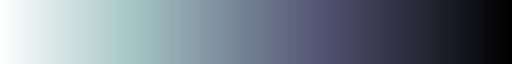

In [79]:
import os
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
sns.color_palette("bone_r", as_cmap=True)

## **2.2 Carregamento e Análise do Dataset**

+ Definição dos Caminhos

In [80]:
# Obter o diretório atual de trabalho
base_dir = os.getcwd()

# Construir caminhos relativos aos arquivos
subject_data_file = os.path.join(base_dir, 'data_subjects_info.csv')
data_dir = os.path.join(base_dir, 'A_DeviceMotion_data')

# Verificar se os diretórios e arquivos existem
if not os.path.exists(data_dir):
    raise FileNotFoundError(f"O diretório {data_dir} não foi encontrado.")

if not os.path.exists(subject_data_file):
    raise FileNotFoundError(f"O arquivo {subject_data_file} não foi encontrado.")

+ Mudança de Diretório

In [81]:
os.chdir(data_dir)
os.chdir(os.pardir)

+ Função para Obter Todos os Caminhos dos Arquivos do Conjunto de Dados

Neste projeto, vai-se desenvolver um modelo de deep learning utilizando Redes Neuronais Recorrentes (RNNs) para classificar atividades de movimento com base em dados sensoriais capturados por sensores de movimento. O conjunto de dados utilizado contém informações sobre seis atividades diferentes: 

   + dws: descer escadas;

   + ups: subir escadas;

   + sit: sentar;

   + std: ficar em pé;

   + wlk: caminhar;

   + jog: correr.

Para simplificar a complexidade e focar na eficácia do modelo, decidimos restringir a previsão a apenas três dessas seis atividades. Portanto, o objetivo será prever, com base nos dados de movimento dos utilizadores, apenas três das seguintes atividades:

   + ups;

   + wlk;

   + sit.


A escolha dessas três atividades foi feita de forma aleatória.


`get_all_dataset_paths`: Percorre recursivamente todos os subdiretórios em input_dir e recolhe os caminhos de todos os arquivos CSV encontrados.

In [82]:
def get_all_dataset_paths(input_dir) -> []:
    input_files = []
    for dirs, subdirs, files in os.walk(input_dir):
        for file in files:
            if file.endswith('.csv'):
                dir_name = os.path.basename(dirs)
                if dir_name.startswith(('ups', 'wlk', 'sit')):
                    input_files.append(os.path.join(dirs, file))
    return input_files

+ Função para Carregar os Dados e Combinar com Metadados

`load_whole_dataframe_from_paths`: Carrega cada arquivo CSV listado em paths, adiciona colunas de metadados (subject_id, session_id, category, age, gender, height, weight) e concatena todos os dados em um único DataFrame.

In [83]:
def load_whole_dataframe_from_paths(paths, meta) -> pd.DataFrame:
    
    df = pd.DataFrame()

    for p in paths:
        c_dir, c_file = p.split('\\')[-2], p.split('\\')[-1]
        c_cat, c_ses = c_dir.split('_')[-2], c_dir.split('_')[-1]
        c_sub = c_file.split('_')[-1].split('.')[-2]
        
        tdf = pd.read_csv(p, encoding = "utf-8")
        tdf = tdf.assign(subject_id = int(c_sub))
        tdf = tdf.assign(session_id = int(c_ses))
        tdf = tdf.assign(category = str(c_cat))
        tdf = tdf.assign(age = int(meta.age[int(c_sub) - 1]))
        tdf = tdf.assign(gender = int(meta.gender[int(c_sub) - 1]))
        tdf = tdf.assign(height = int(meta.height[int(c_sub) - 1]))
        tdf = tdf.assign(weight = int(meta.weight[int(c_sub) - 1]))

        df = pd.concat([df, tdf])
    
    df.reset_index(drop=True, inplace=True)
    return df

+ Carregar os Metadados e Todos os Caminhos dos Arquivos do Conjunto de Dados

`subject_data_frame`: Carrega os metadados dos sujeitos a partir do arquivo CSV.

`all_dataset_paths`: Obtém todos os caminhos dos arquivos CSV no diretório de dados.

`data_frame`: Carrega e combina todos os dados dos arquivos CSV com os metadados.

In [84]:
subject_data_frame = pd.DataFrame(pd.read_csv(subject_data_file, encoding = "utf-8"))
all_dataset_paths = get_all_dataset_paths(data_dir)

df_motionSense = load_whole_dataframe_from_paths(all_dataset_paths, subject_data_frame)

In [85]:
#linha_filtrada = df_motionSense.loc[(df_motionSense['session_id'] == 5) & (df_motionSense['category'] == 'sit')]
#linha_filtrada

+ Save the concatenated dataset using `to_cvs()` method

In [86]:
output_file_path = os.path.join(base_dir, 'concatDataset.csv')

df_motionSense.to_csv(output_file_path, index=False)

In [87]:
df_motionSense.head(10)

,Unnamed: 0,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z,subject_id,session_id,category,age,gender,height,weight
0,0,0.351138,-0.416302,-0.098023,0.314588,0.404381,-0.858784,-0.003655,0.009577,-0.000234,0.000094,0.000252,-0.006954,1,13,sit,46,1,188,102
1,1,0.351219,-0.416372,-0.098025,0.314649,0.404445,-0.858732,-0.007937,0.007457,0.000807,-0.001309,0.002262,-0.010348,1,13,sit,46,1,188,102
2,2,0.351145,-0.416497,-0.098045,0.314567,0.404560,-0.858708,-0.007960,-0.001053,-0.002387,-0.002174,0.000012,-0.006664,1,13,sit,46,1,188,102
3,3,0.350849,-0.416695,-0.098148,0.314286,0.404740,-0.858726,-0.000521,-0.006411,-0.001261,0.001693,0.009216,-0.011575,1,13,sit,46,1,188,102
4,4,0.350859,-0.416863,-0.098022,0.314271,0.404894,-0.858658,-0.001613,-0.004306,0.006206,0.005767,0.007490,-0.008926,1,13,sit,46,1,188,102
5,5,0.350996,-0.416829,-0.097836,0.314393,0.404863,-0.858628,-0.001579,0.004212,0.007264,0.004180,0.001997,-0.006957,1,13,sit,46,1,188,102
6,6,0.351274,-0.416695,-0.097757,0.314650,0.404740,-0.858592,0.000549,0.010665,0.000755,0.003312,0.000014,-0.006520,1,13,sit,46,1,188,102
7,7,0.351431,-0.416756,-0.097721,0.314777,0.404797,-0.858519,-0.004833,0.002154,0.002865,0.000653,0.008991,-0.006990,1,13,sit,46,1,188,102
8,8,0.351272,-0.416737,-0.097922,0.314643,0.404779,-0.858577,0.002659,-0.004217,-0.008825,-0.000526,-0.003076,-0.008138,1,13,sit,46,1,188,102
9,9,0.351340,-0.416674,-0.098074,0.314711,0.404722,-0.858579,0.007998,-0.002109,-0.007722,0.006044,0.005267,-0.006274,1,13,sit,46,1,188,102


## **2.5 Visualizing Categorical Data Distribution**

We use Seaborn and Matplotlib to create a countplot, visualizing the distribution of numerical codes in the 'code' column of the DataFrame 'df.' This plot provides insight into the frequency of different categories in the dataset.

In [88]:
pd.isna(df_motionSense).sum()

Unnamed: 0            0
attitude.roll         0
attitude.pitch        0
attitude.yaw          0
gravity.x             0
gravity.y             0
gravity.z             0
rotationRate.x        0
rotationRate.y        0
rotationRate.z        0
userAcceleration.x    0
userAcceleration.y    0
userAcceleration.z    0
subject_id            0
session_id            0
category              0
age                   0
gender                0
height                0
weight                0
dtype: int64

In [89]:
category_counts = df_motionSense['category'].value_counts()
category_counts

category
wlk    344288
sit    338778
ups    157285
Name: count, dtype: int64

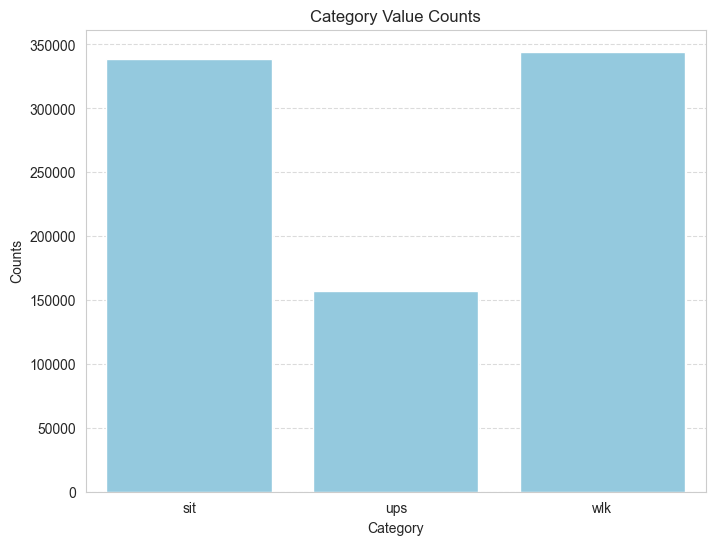

In [90]:
#category_counts = df_motionSense['category'].value_counts()

plt.figure(figsize=(8, 6))
sns.countplot(df_motionSense, x='category', color='skyblue')
plt.title('Category Value Counts')
plt.xlabel('Category')
plt.ylabel('Counts')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.show()

In [91]:
print(df_motionSense.dtypes)

Unnamed: 0              int64
attitude.roll         float64
attitude.pitch        float64
attitude.yaw          float64
gravity.x             float64
gravity.y             float64
gravity.z             float64
rotationRate.x        float64
rotationRate.y        float64
rotationRate.z        float64
userAcceleration.x    float64
userAcceleration.y    float64
userAcceleration.z    float64
subject_id              int64
session_id              int64
category               object
age                     int64
gender                  int64
height                  int64
weight                  int64
dtype: object


In [92]:
df_motionSense.describe()

,Unnamed: 0,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z,subject_id,session_id,age,gender,height,weight
count,840351.000000,840351.000000,840351.000000,840351.000000,840351.000000,840351.000000,840351.000000,840351.000000,840351.000000,840351.000000,840351.000000,840351.000000,840351.000000,840351.000000,840351.000000,840351.000000,840351.000000,840351.000000,840351.000000
mean,3068.107853,-0.155895,-0.810146,-0.038124,0.067385,0.645313,-0.210860,0.004354,0.079019,0.014295,-0.011920,0.046798,0.056178,12.380254,7.585436,28.896167,0.576855,174.128807,72.258687
std,2502.791208,1.483749,0.503567,1.380336,0.377500,0.352105,0.517760,1.220849,1.100158,0.726100,0.275738,0.396086,0.328711,6.916785,3.612695,5.313965,0.494058,8.819309,15.945094
min,0.000000,-3.141583,-1.569974,-3.141583,-0.893495,-0.999993,-0.999999,-8.475164,-11.828803,-9.093616,-3.429830,-3.325982,-4.429538,1.000000,3.000000,18.000000,0.000000,161.000000,48.000000
25%,1104.000000,-1.243680,-1.249373,-0.890846,-0.200247,0.377040,-0.654381,-0.436766,-0.109786,-0.145583,-0.066203,-0.078439,-0.015371,6.000000,5.000000,25.000000,0.000000,164.000000,60.000000
50%,2394.000000,0.237074,-0.938127,-0.069244,0.071129,0.806452,-0.248512,-0.000527,0.001036,0.000145,0.001456,0.004309,0.000108,12.000000,7.000000,28.000000,1.000000,175.000000,72.000000
75%,4459.000000,0.717692,-0.386599,0.661591,0.365581,0.948787,0.089424,0.174542,0.385849,0.169866,0.044790,0.100516,0.145885,18.000000,8.000000,31.000000,1.000000,180.000000,88.000000
max,12756.000000,3.141579,1.567175,3.141584,0.999998,1.000000,0.981312,6.988259,10.157325,8.028294,2.876603,5.114609,4.352533,24.000000,15.000000,46.000000,1.000000,190.000000,102.000000


<Figure size 2400x800 with 0 Axes>

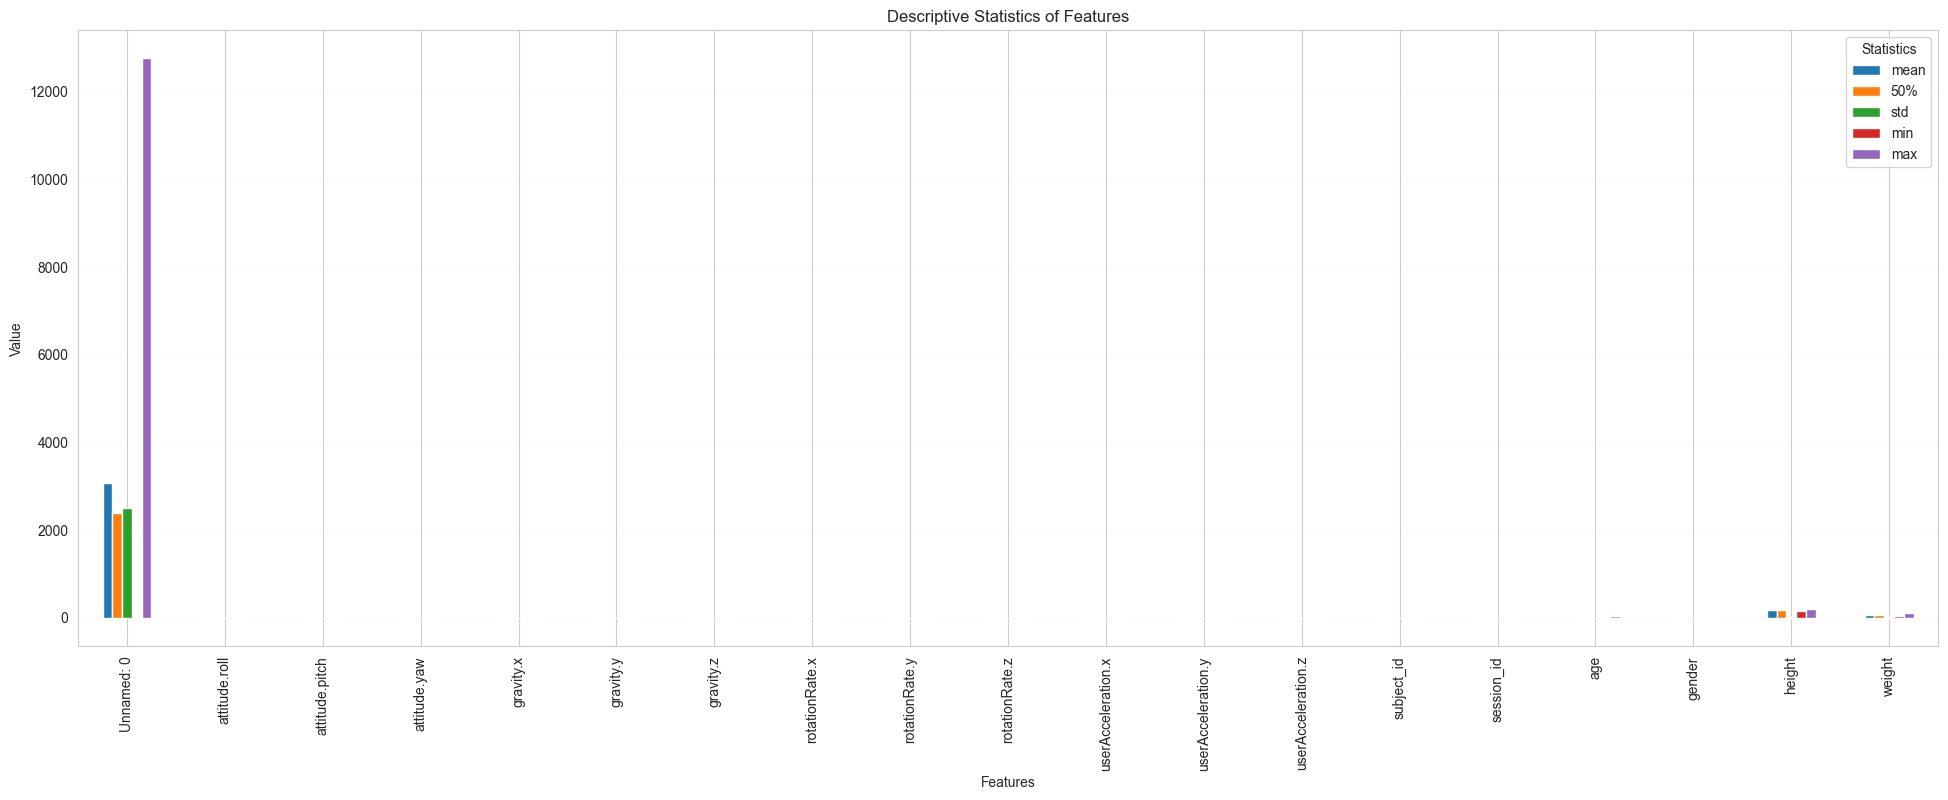

In [93]:
# Supondo que df_motionSense já esteja definido
description = df_motionSense.describe()

plt.figure(figsize=(24, 8))

# Transpor o DataFrame e plotar as estatísticas selecionadas
description.transpose()[['mean', '50%', 'std', 'min', 'max']].plot(kind='bar', figsize=(24, 8))

plt.title('Descriptive Statistics of Features')
plt.ylabel('Value')
plt.xlabel('Features')
plt.grid(axis='y', linestyle='--', alpha=0.1)
plt.xticks(rotation=90)
plt.legend(title='Statistics')
plt.show()

In [94]:
features = list(df_motionSense.columns)
for feature in features:
    print(feature + " - " + str(len(df_motionSense[df_motionSense[feature].isna()])))

Unnamed: 0 - 0
attitude.roll - 0
attitude.pitch - 0
attitude.yaw - 0
gravity.x - 0
gravity.y - 0
gravity.z - 0
rotationRate.x - 0
rotationRate.y - 0
rotationRate.z - 0
userAcceleration.x - 0
userAcceleration.y - 0
userAcceleration.z - 0
subject_id - 0
session_id - 0
category - 0
age - 0
gender - 0
height - 0
weight - 0
